In [19]:
%load_ext autoreload
%reload_ext autoreload
%env JAX_PLATFORM_NAME=cpu

import jaxtyping  # noqa: F401

%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: JAX_PLATFORM_NAME=cpu
The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


In [20]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax

import matplotlib.pyplot as plt

from jaxtyping import Float, Array, Int

from n3.architecture.controller import IdentityController, ControllerLike
from n3.architecture.model import N3, ModelLike

from n3.utils.utils import grad_norm
from n3.utils.metrics import accuracy, cross_entropy, confusion_matrix


In [21]:
from mnist1d.data import make_dataset, get_dataset_args

### Config

In [22]:
n_samples = 2**15
test_size = 0.2

seed = 42
key = jax.random.PRNGKey(seed)
N_max = 200  # per layer max number of neurons
size_influence = 1.0
epochs = 5_000
print_every = 100

### Dataset

In [23]:
data_args = get_dataset_args(as_dict=True)

print(data_args)

{'num_samples': 5000, 'train_split': 0.8, 'template_len': 12, 'padding': [36, 60], 'scale_coeff': 0.4, 'max_translation': 48, 'corr_noise_scale': 0.25, 'iid_noise_scale': 0.02, 'shear_scale': 0.75, 'shuffle_seq': False, 'final_seq_length': 40, 'seed': 42, 'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}


In [24]:
dataset_args = get_dataset_args()
dataset_args.num_samples = n_samples
dataset_args.seed = seed

data = make_dataset(dataset_args)

In [25]:
x_train, y_train, x_test, y_test = data["x"], data["y"], data["x_test"], data["y_test"]

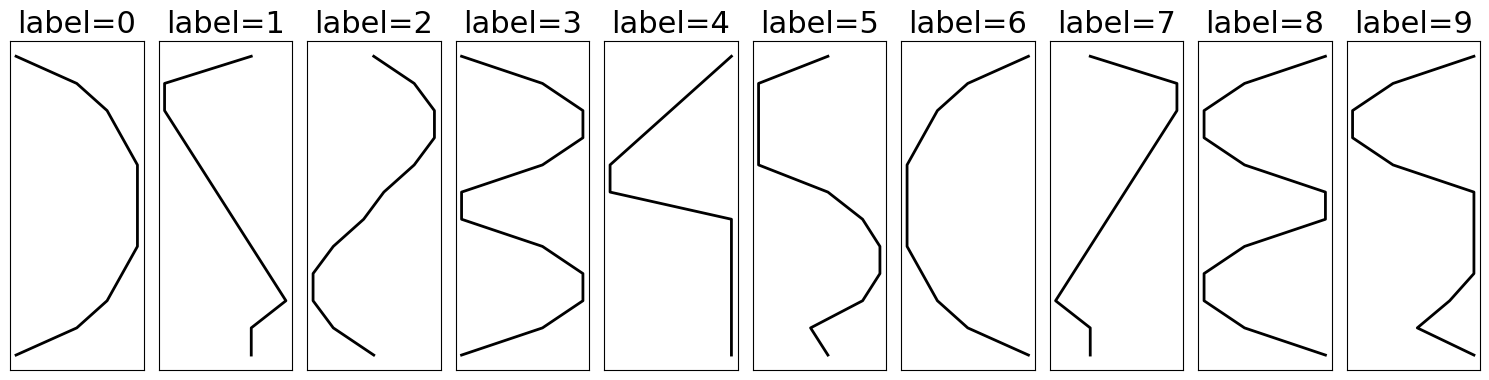

In [26]:
xs = data["templates"]["x"]
t = data["templates"]["t"]
labels = data["templates"]["y"]

fig = plt.figure(figsize=(15, 1.5 * 2.6))

for c in range(10):
    ix = c
    x, t = xs[ix], t
    ax = plt.subplot(1, 10, ix + 1)

    plt.plot(x, t, "k-", linewidth=2)
    plt.gca().invert_yaxis()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("label=" + str(labels[ix]), fontsize=22)
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()


In [27]:
# x_train, x_test, y_train, y_test = mnist1d.generate_data(
#     n_samples=n_samples,
#     test_size=test_size,
#     scaler=MinMaxScaler(feature_range=(-1, 1)),
#     seed=seed,
# )

### Training scheme

In [28]:
def compute_base_loss(
    model: ModelLike,
    control: ControllerLike,
    x: Float[Array, "batch input_dim"],
    y: Int[Array, "batch"],
) -> Float[Array, ""]:
    pred_y = jax.nn.log_softmax(jax.vmap(model, in_axes=(0, None))(x, control))
    loss = cross_entropy(y, pred_y)
    return loss

In [29]:
def compute_size_loss(
    controller: ControllerLike, size_influence: float
) -> Float[Array, ""]:
    N = controller(jnp.ones((1,)))
    return size_influence * jnp.mean((N - 1.0) ** 2)

In [30]:
@eqx.filter_jit
def make_step(
    model: ModelLike,
    controller: ControllerLike,
    size_influence: float,
    x: Float[Array, "batch input_dim"],
    y: Int[Array, "batch"],
    optim: optax.GradientTransformation,
    opt_state: optax.OptState,
) -> tuple[Float[Array, ""], ModelLike, ControllerLike, optax.OptState]:
    loss_base, grads_base = eqx.filter_value_and_grad(compute_base_loss)(
        model, controller, x, y
    )
    loss_size, grads_size = eqx.filter_value_and_grad(compute_size_loss)(
        controller, size_influence
    )
    loss = loss_base + loss_size

    updates, opt_state = optim.update([grads_base, grads_size], opt_state)

    model = eqx.apply_updates(model, updates[0])  # type: ignore
    controller = eqx.apply_updates(controller, updates[1])  # type: ignore
    return loss, model, controller, opt_state

In [31]:
@eqx.filter_jit
def test_step(
    model: ModelLike,
    controller: ControllerLike,
    size_influence: float,
    x: Float[Array, "batch input_dim"],
    y: Int[Array, "batch"],
) -> Float[Array, ""]:
    return compute_base_loss(model, controller, x, y) + compute_size_loss(
        controller, size_influence
    )

In [32]:
model_key, control_key = jax.random.split(key)
n3 = N3(40, 10, [N_max], model_key)
control = IdentityController(1, control_key)

optim = optax.adam(learning_rate=3e-4)
opt_state = optim.init(eqx.filter([n3, control], eqx.is_inexact_array))

In [33]:
epoch_list = []
test_losses = []
test_accuracies = []
train_losses = []
controls = []
base_grad_norms = []
control_grad_norms = []

for epoch in range(epochs):
    train_loss, n3, control, opt_state = make_step(
        n3, control, size_influence, x_train, y_train, optim, opt_state
    )

    if epoch % print_every == 0:
        epoch_list.append(epoch)
        test_loss = test_step(n3, control, size_influence, x_test, y_test)
        test_accuracy = accuracy(n3, control, x_test, y_test)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        train_losses.append(train_loss)
        controls.append(control.params.item())
        control_grad_norms.append(
            grad_norm(eqx.filter_grad(compute_size_loss)(control, size_influence))
        )
        print(
            f"epoch: {epoch_list[-1]}, train_loss: {train_losses[-1]:.4e}, test_loss: {test_losses[-1]:.4e}, test_accuracy: {test_accuracies[-1]:.4f}"
        )
        print(
            f"control2: {controls[-1]:.4e}, Control_grad_norm: {control_grad_norms[-1]:.4e}"
        )

epoch: 0, train_loss: 2.3443e+00, test_loss: 2.3316e+00, test_accuracy: 0.0856
control2: 1.0000e+00, Control_grad_norm: 0.0000e+00
epoch: 100, train_loss: 1.7869e+00, test_loss: 1.7841e+00, test_accuracy: 0.3004
control2: 1.0000e+00, Control_grad_norm: 0.0000e+00
epoch: 200, train_loss: 1.6521e+00, test_loss: 1.6509e+00, test_accuracy: 0.3495
control2: 1.0000e+00, Control_grad_norm: 0.0000e+00
epoch: 300, train_loss: 1.5795e+00, test_loss: 1.5798e+00, test_accuracy: 0.3806
control2: 1.0000e+00, Control_grad_norm: 0.0000e+00
epoch: 400, train_loss: 1.5079e+00, test_loss: 1.5095e+00, test_accuracy: 0.4171
control2: 1.0000e+00, Control_grad_norm: 0.0000e+00
epoch: 500, train_loss: 1.4304e+00, test_loss: 1.4338e+00, test_accuracy: 0.4570
control2: 1.0000e+00, Control_grad_norm: 0.0000e+00
epoch: 600, train_loss: 1.3521e+00, test_loss: 1.3583e+00, test_accuracy: 0.4982
control2: 1.0000e+00, Control_grad_norm: 0.0000e+00
epoch: 700, train_loss: 1.2739e+00, test_loss: 1.2841e+00, test_accurac

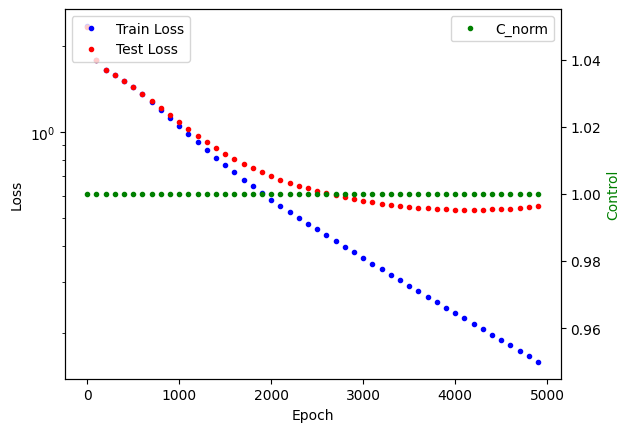

In [34]:
fig, ax1 = plt.subplots()

# Plotting train and test losses
ax1.plot(epoch_list, train_losses, "b.", label="Train Loss")
ax1.plot(epoch_list, test_losses, "r.", label="Test Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="k")
ax1.set_yscale("log")
# ax1.set_xscale("log")

# Creating a second y-axis to plot control gradient norms
ax2 = ax1.twinx()
ax2.plot(
    epoch_list, jnp.sin((jnp.pi / 2) * jnp.array(controls)) ** 2, "g.", label="C_norm"
)
ax2.set_ylabel("Control", color="g")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

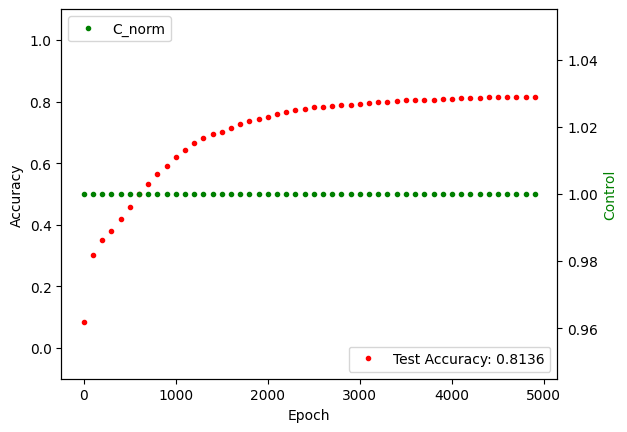

In [35]:
fig, ax1 = plt.subplots()

# Plotting train and test losses
ax1.plot(
    epoch_list, test_accuracies, "r.", label=f"Test Accuracy: {test_accuracies[-1]:.4f}"
)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy", color="k")
ax1.set_ylim(-0.1, 1.1)
# ax1.set_xscale("log")

# Creating a second y-axis to plot control gradient norms
ax2 = ax1.twinx()
ax2.plot(
    epoch_list, jnp.sin((jnp.pi / 2) * jnp.array(controls)) ** 2, "g.", label="C_norm"
)
ax2.set_ylabel("Control", color="g")

ax1.legend(loc="lower right")
ax2.legend(loc="upper left")
plt.show()

Text(0.5, 1.0, 'Confusion matrix')

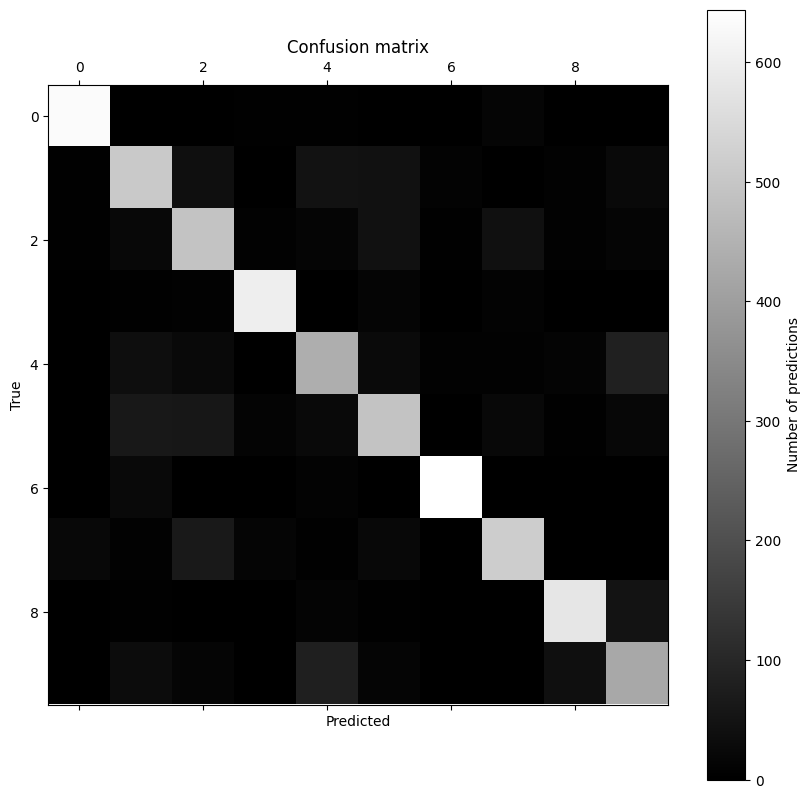

In [36]:
cmat = confusion_matrix(n3, control, x_test, y_test)

fig, ax = plt.subplots(figsize=[10, 10])
cax = ax.matshow(cmat, cmap="gray")
fig.colorbar(cax, label="Number of predictions")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")